## This code produces Figure 4 (bottom) in the paper.

### Packages and settings

In [6]:
import os, sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
import torch.nn as nn 

from lampe import plots

sys.path.append('../')
from utils import datasets
import utils.resnet_cond as resnet
import utils.lightning_flows as LFlows


In [2]:
# use GPUs if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: %s'%(device))

Device: cuda


### Plots

In [4]:
# Load maps and parameters from the CV set.
home_dir   = Path("/n/netscratch/dvorkin_lab/Lab/aakhmetzhanova/evidence-estimation-Astrid/") 

field    = 'Mgas'
splits   = 15
n_params = 6
params  = np.loadtxt(home_dir / 'data/params_CV_Astrid.txt',)[:, :n_params]
minimum = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])[:n_params]
maximum = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])[:n_params]
params  = (params - (minimum+maximum)/2)/((maximum - minimum)/2)   # rescale parameters
params  = np.repeat(params[:, None, :], splits, axis = 1)          # reshape the parameters to match the shape of the maps 
params  = torch.tensor(params).float()

grid     = 256
BoxSize  = 25
maps     = np.load(home_dir / f'data/2D/Maps_{field}_Astrid_CV_z=0.00.npy')
maps     = maps.reshape(params.shape[0], -1, 1, grid, grid)[:, :splits]
maps     = torch.tensor(maps).float()

# Load normalization constants.
maps_LH     = np.load(home_dir / f'data/2D/Maps_{field}_Astrid_LH_z=0.00.npy')
maps_mean, maps_std = np.log10(maps_LH).mean(), np.log10(maps_LH).std()

# Choose a set of smoothing scales to plot constraints for.
k_smooth_array     = np.array([2., 5.64621617, 45.])

In [5]:
# Load summarizer and parameter estimation network.
npe_k_cond = False
n_params   = 6
summary_dim = 40

save_dir   = home_dir / f'trained_models/Maps_{field}/'
checkpoint = save_dir / f'summarizer_scale_cond_{field}_Astrid/'
checkpoint = checkpoint / 'k_conv_lr_1e-4/checkpoints/best_val_loss.ckpt'

model      = LFlows.LightningFlowCond.load_from_checkpoint(checkpoint, 
                                                           device=device,
                                                           k_cond='conv',
                                                           npe_k_cond=npe_k_cond,
                                                           summary_dim=40, n_params=n_params,
                                                           model_name='resnet10t.c3_in1k',)
model.summarizer.eval();
model.density_estimator.eval();


In [7]:
# Draw predicted parameters for the smoothing scales above using a trained compressor and parameter estimator networks.
seed       = 1
batch_size = 500
train_frac, valid_frac, test_frac = 0., 0., 1.
k_min, k_max = 2., 45.

# Simulation index
sim_idx  = 0
params_true_all_scales = []
params_pred_all_scales = []
errors_pred_all_scales = []
summaries_all_scales   = []

maps_plot_all_scales   = []

# Draw predicted parameters for 
for k_smooth in k_smooth_array:
    
    params_true = []
    params_pred = []
    errors_pred = []
    summaries_  = []
    maps_plot = []
    
    _, _, test_dset = datasets.create_datasets_maps(maps, params, 
                                                   train_frac, valid_frac, test_frac, 
                                                   seed=seed, rotations=False, 
                                                   smoothing=True, k_smooth=k_smooth,
                                                   k_min=k_min, k_max=k_max,
                                                   normalize_k=True,
                                                   linear=False, log_scale=True, 
                                                   standardize=True, 
                                                   maps_mean=maps_mean, maps_std=maps_std,) 
    dataloader  = DataLoader(test_dset, batch_size, shuffle = False,)
    
    for maps_test, params_test, k_test in dataloader:
        with torch.no_grad():
            maps_test    = maps_test.float().to(device=device)
            params_test  = params_test.float().to(device=device)
            k_test       = k_test.float().to(device=device)
            bs           = maps_test.shape[0]
            
            summaries    = model.summarizer([maps_test, k_test])
            if npe_k_cond:
                summaries    = torch.cat((summaries, k_test), dim=1)
            
            params_samples = model.density_estimator(summaries[splits*sim_idx:splits*(sim_idx+1)]).sample((50_000,))
            params_samples = params_samples.detach().cpu().numpy()
            params_samples = params_samples*(maximum[None, None, :] - minimum[None, None, :])/2 + (minimum[None, None, :]+maximum[None, None, :])/2  

            params_test    = params_test.detach().cpu().numpy()
            params_test    = params_test*(maximum[None, :] - minimum[None, :])/2 + (minimum[None, :]+maximum[None, :])/2  


            params_true    = params_test[sim_idx]
            params_pred    = params_samples
            maps_plot      = maps_test.cpu().detach().numpy()[splits*sim_idx:splits*(sim_idx+1)]

    params_true_all_scales.append(params_true)
    params_pred_all_scales.append(params_pred)
    maps_plot_all_scales.append(maps_plot)
    
params_true_all_scales = np.array(params_true_all_scales)
params_pred_all_scales = np.array(params_pred_all_scales)
maps_plot_all_scales   = np.array(maps_plot_all_scales)

print(params_true_all_scales.shape, params_pred_all_scales.shape, maps_plot_all_scales.shape)

(3, 6) (3, 50000, 15, 6) (3, 15, 1, 256, 256)


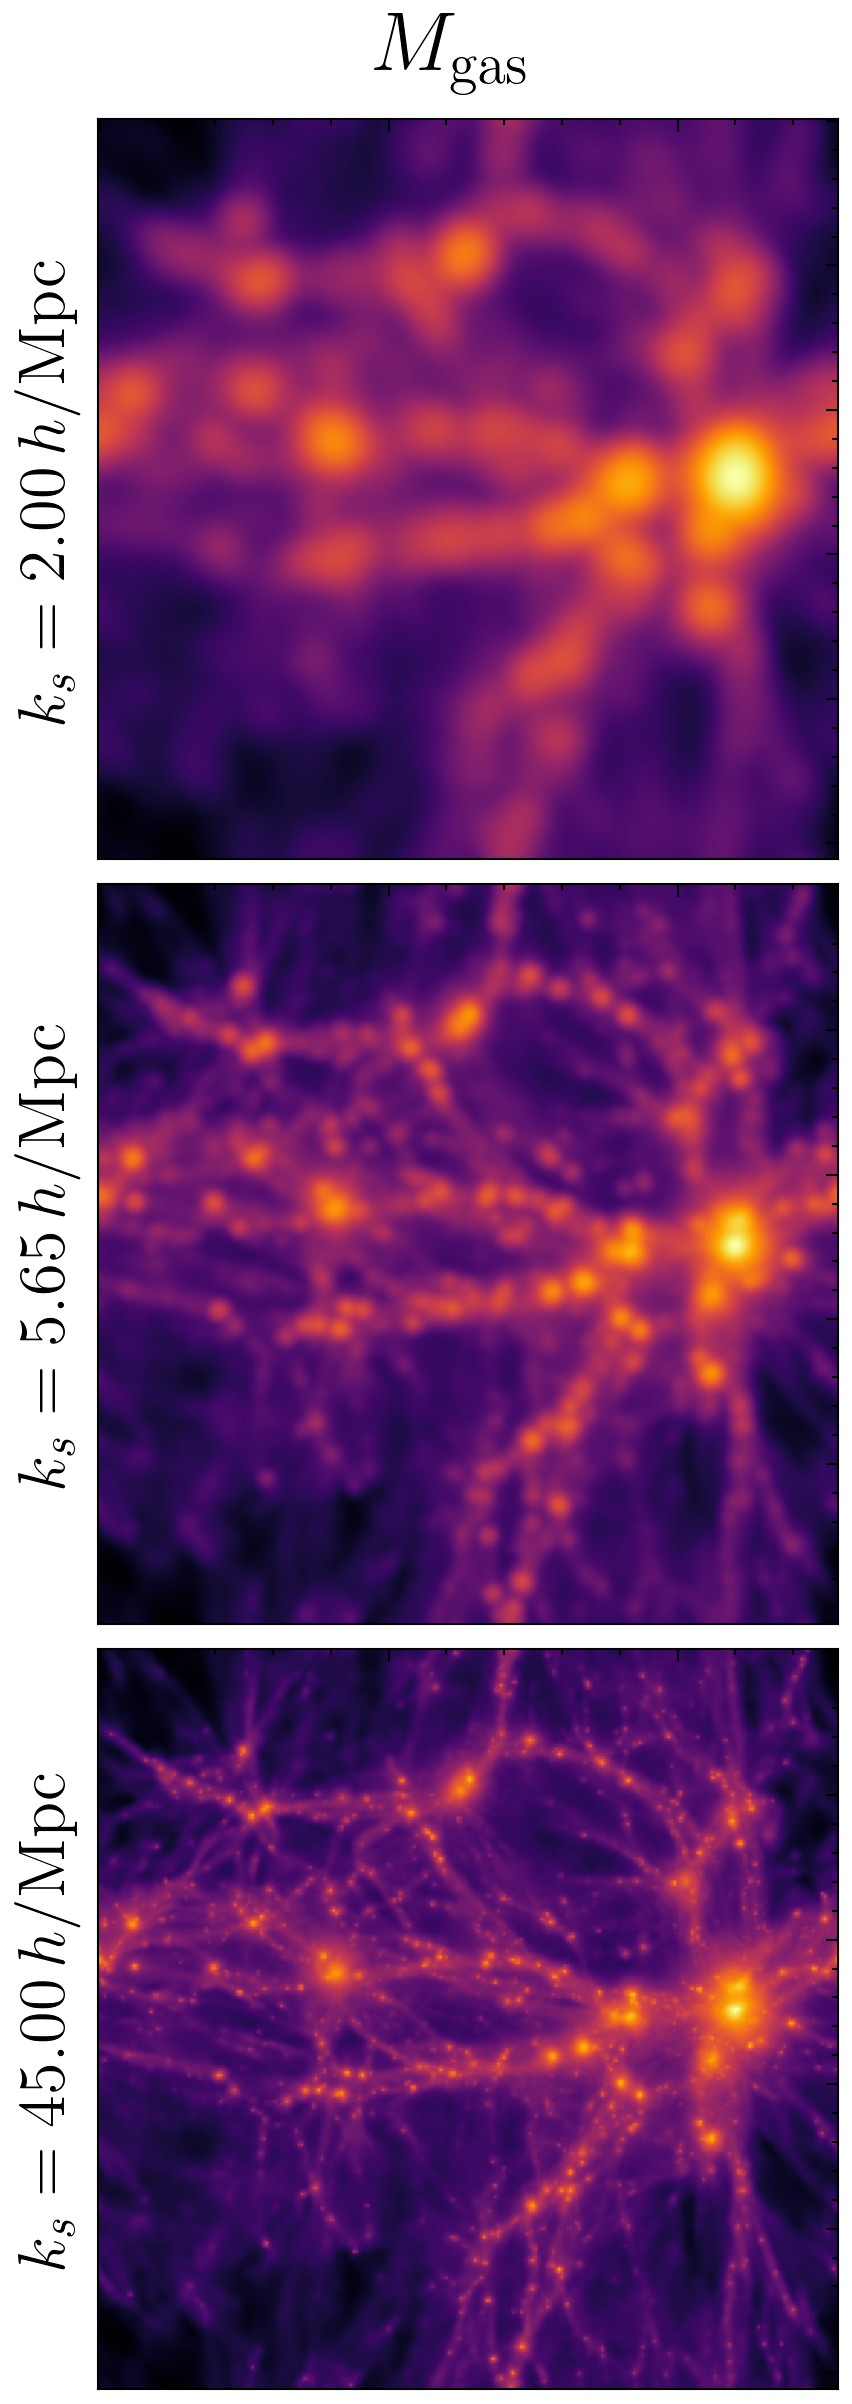

In [8]:
# Plot the same map for different smoothing scales in k_smooth_array.
map_idx = 2

plt.style.use(['science'])
fig, axs = plt.subplots(3, 1, figsize=(3, 8), layout='constrained', dpi=300)
fig.suptitle(r'$M_{\mathrm{gas}}$', fontsize=20)
for col in range(len(axs)):
    ax = axs[col]
    ax.set_ylabel(r'$k_s={:.2f} \, h/$'.format(k_smooth_array[col]) +r'$\mathrm{Mpc}$', 
                 fontsize=16,)
    
    pcm = ax.imshow(maps_plot_all_scales[col, map_idx, 0],cmap = 'inferno')
    ax.set_aspect('equal')
    ax.tick_params(axis='both',       
                   which='both',                     
                   labelbottom=False, bottom=False,
                   left=False, labelleft=False, )   

plt.savefig(f'plots/2_smooth_maps_{field}.pdf')
plt.show()

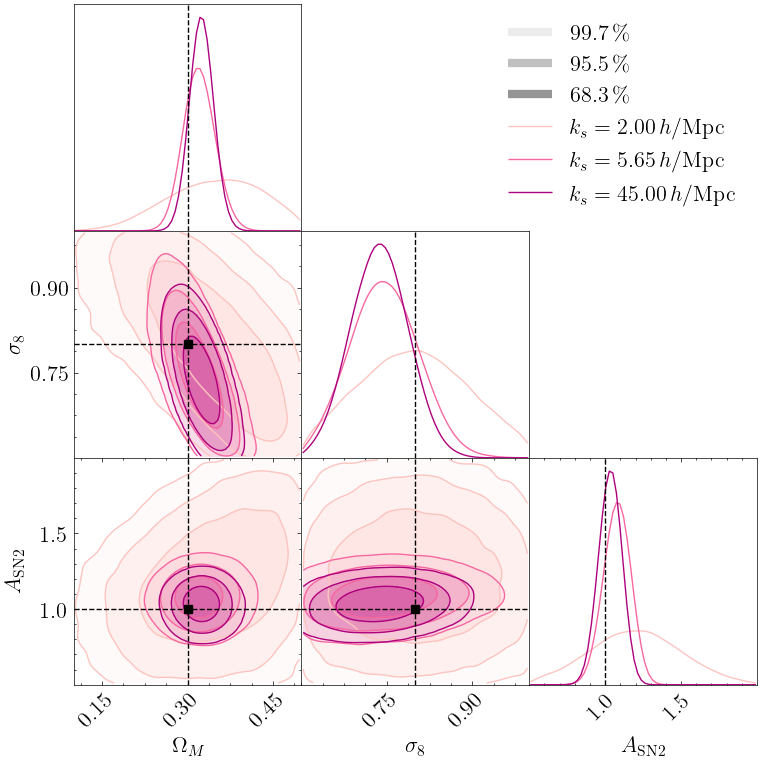

In [9]:
plt.rcParams.update({'legend.fontsize': 16, 'font.size': 16.0,})
plt.style.use(['science'])

# Plot samples drawn from NPE for the maps shown above
colors = ['#fcc5c0','#f768a1','#ae017e',] 
smooth  = 2
labels  = [r'$\Omega_M$', r'$\sigma_8$', r'$A_{\rm SN2}$']
domain = ([0.1, 0.6, 0.5], [0.5, 1.0, 2.])

fig = plots.corner(params_pred_all_scales[0, :, map_idx, [0, 1, 4]].T, 
                   smooth=smooth, 
                   domain=domain,
                   labels=labels, 
                   legend=r'$k_s={:.2f} \, h/$'.format(k_smooth_array[0])  +r'$\mathrm{Mpc}$', 
                   color=colors[0],
                   figsize=(8, 8),
                   ) 
plots.corner(params_pred_all_scales[1, :, map_idx, [0, 1, 4]].T, 
             smooth=smooth, 
             domain=domain,
             figure=fig, 
             legend=r'$k_s={:.2f} \, h/$'.format(k_smooth_array[1])  +r'$\mathrm{Mpc}$', 
             color=colors[1],)
plots.corner(params_pred_all_scales[2, :, map_idx, [0, 1, 4]].T, 
             smooth=smooth, 
             domain=domain,
             figure=fig, 
             legend=r'$k_s={:.2f} \, h/$'.format(k_smooth_array[2])  +r'$\mathrm{Mpc}$', 
             color=colors[2],)
plots.mark_point(fig, [0.3, 0.8, 1.], color='black',)
plt.savefig(f'plots/2_npe_constraints_single_map_{field}.pdf')
plt.show(fig)